# NLP tf-idf pipeline with scikit-learn

In [1]:
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start
        
def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Helper Functions

In [4]:
def read_data(parquet_path):
    data = pd.read_parquet(parquet_path)
    return data

def text_preprocessor(data, column_name, PUNCTUATIONS, STOPWORDS):
    data = data[data[column_name].notna()]
    # from https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
    transtable = str.maketrans(dict.fromkeys("".join(PUNCTUATIONS), ''))
    data.loc[:,column_name] = (data[column_name].str.lower()
                           .str.translate(transtable)
                           .str.strip())
    data.loc[:,column_name] = data[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))                    
    return data

def hashing_vectorizer(data, column_name):
    vectorizer = HashingVectorizer(stop_words='english', preprocessor=None)
    hashing_vectorized = vectorizer.fit_transform(data[column_name])
    return hashing_vectorized

def tfidf_transformer(hashing_vectorized, column_name):
    transformer = TfidfTransformer()
    result = transformer.fit_transform(hashing_vectorized)
    return result

def execute_full_pipeline(n, i):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    with SimpleTimer() as timer:
        data = read_data(parquet_path)
    sample_record["data_read"]=timer.elapsed

    with SimpleTimer() as timer:
        data = text_preprocessor(data, "review_body", PUNCTUATIONS, STOPWORDS)
    sample_record["data_preprocessing"]=timer.elapsed
    
    with SimpleTimer() as timer:
        hashing_vectorized = hashing_vectorizer(data,"review_body")
    sample_record["hashing_vectorizer"]=timer.elapsed
    
    with SimpleTimer() as timer:
        result = tfidf_transformer(hashing_vectorized, "review_body")
    sample_record["tfidf_transformer"]=timer.elapsed
    
    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, result, sample_record
    

## Benchmarking Code

In [ ]:
def performance_numbers(parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl"):
    """
    Main function to perform the performance sweep
    """
    overall_perf_result = {}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, result, sample_record = execute_full_pipeline(n, i)
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=data.shape[0]
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)

In [5]:
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
model_kwargs = {"text_preprocessor":text_preprocessor}
samples = 2
worker_counts = [1]
result_path = f"./results/result_poc_nlp_sklearn_{dataset}.pkl"

In [6]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples,result_path=result_path)

  0%|                                                                                                                                                                                      | 0/2 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1/2 [1:16:08<1:16:08, 4568.46s/it]

Workers:1, Sample Run:0, Finished loading data in 65566707874s
Workers:1, Sample Run:0, Finished preprocessing data in 3613391457736s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 822959990784s
Workers:1, Sample Run:0, Finished fitting IDF Transformer in 66347255200s
Workers:1, Sample Run:0, Finished executing full pipeline in 4568455170533s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [2:33:27<00:00, 4603.98s/it]

Workers:1, Sample Run:1, Finished loading data in 66590494444s
Workers:1, Sample Run:1, Finished preprocessing data in 3635688891222s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 826569410713s
Workers:1, Sample Run:1, Finished fitting IDF Transformer in 110423009980s
Workers:1, Sample Run:1, Finished executing full pipeline in 4639508578517s
CPU times: user 2h 31min 33s, sys: 9min 35s, total: 2h 41min 9s
Wall time: 2h 33min 28s


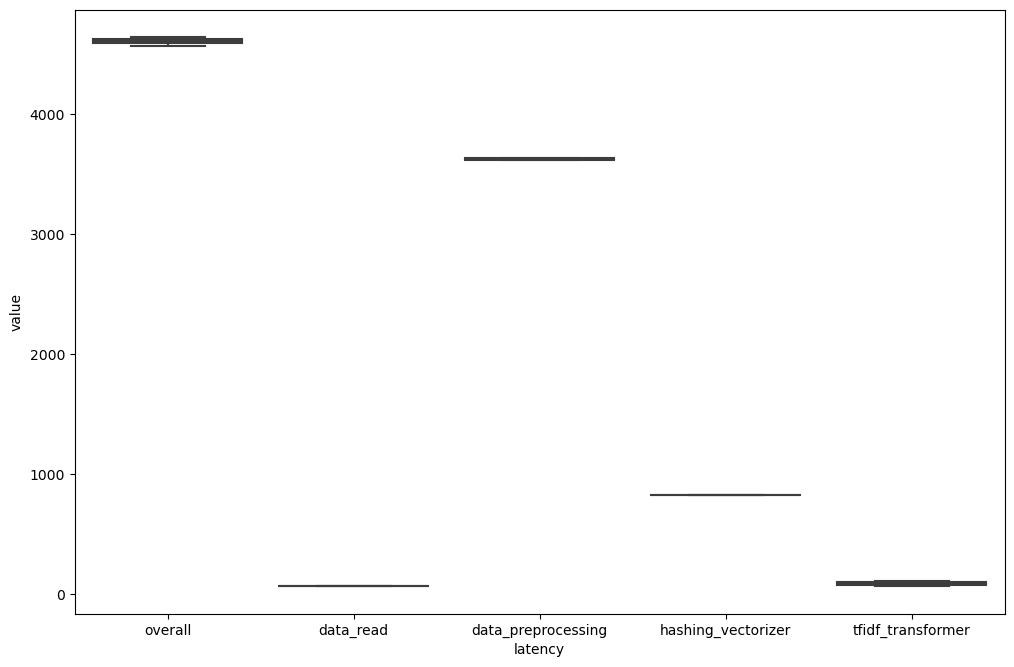

In [7]:
data, melt_data = visualize_data(result_path)    

In [8]:
data

,n_workers,sample_run,overall,data_read,data_preprocessing,hashing_vectorizer,tfidf_transformer,nrows
0,1,0,4568.455171,65.566708,3613.391458,822.959991,66.347255,20725971
1,1,1,4639.508579,66.590494,3635.688891,826.569411,110.423010,20725971


In [9]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [10]:
groupy

sample_run                      overall                   data_read  \
                mean       std count         mean        std count       mean   
n_workers                                                                       
1                0.5  0.707107     2  4603.981875  50.242347     2  66.078601   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          0.723926     2        3624.540174  ...     2         824.764701   

                          tfidf_transformer                      nrows       \
                std count              mean        std count      mean  std   
n_workers                                                                     
1          2.552245     2         88.385133  31.166265     2  20725971  0.0   

                 
          count  
n_workers        
1             2  

[1 rows x 21 columns]